In [1]:
%pip install einops
%pip install wandb

     |████████████████████████████████| 1.8MB 4.0MB/s 
     |████████████████████████████████| 102kB 10.0MB/s 
     |████████████████████████████████| 174kB 28.8MB/s 
     |████████████████████████████████| 133kB 35.9MB/s 
     |████████████████████████████████| 71kB 8.7MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=e72c8512e3b5c7a1a883dd3a85173ed1e06952e9dd441d1c1ed02b62ca395dba
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=04961f5661ec28a616b1f7a5bd4535ebf4da94182e6881e705b11374e1fd3bc7
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subprocess32 pathtools


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, layers
from einops import rearrange, repeat
from einops.layers.tensorflow import Rearrange, Reduce

class MLPBlock(layers.Layer):
    def __init__(self, mixing, d_ff):
        super(MLPBlock, self).__init__()
        if mixing != 'token' and mixing != 'channel':
            raise ValueError("undefiend mixing")
        self.mixing = mixing
        self.d_ff = d_ff
        
    def build(self, input_shape):
        d_out = input_shape[-1] if self.mixing=='channel' else input_shape[-2]
        self.dense_1 = layers.Dense(self.d_ff, use_bias=False)
        self.dense_2 = layers.Dense(d_out, use_bias=False)
        self.norm = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        '''
        inputsは(batches, tokens, channels)
        Denseは最後の軸に作用
        '''
        x = self.norm(inputs)
        x = x if self.mixing!='token' else tf.transpose(x, perm=[0, 2, 1])
        x =self.dense_1(x)
        x = tf.keras.activations.gelu(x, approximate=True)
        x = self.dense_2(x)
        x = x if self.mixing!='token' else tf.transpose(x, perm=[0, 2, 1])
        return x + inputs

class MixerBlock(layers.Layer):
    def __init__(self, d_s, d_c):
        super(MixerBlock, self).__init__()
        self.mlp_1 = MLPBlock(mixing='token', d_ff=d_s)
        self.mlp_2 = MLPBlock(mixing='channel', d_ff=d_c)

    def call(self, inputs):
        x = self.mlp_1(inputs)
        x = self.mlp_2(x)
        return x


def build_model(**config):
    shapes = (config['image_size'], config['image_size'], config['channels'])
    hidden_dim  = config['hidden_dim']
    patch_size = config['patch_size']
    num_blocks = config['depth']
    tokens_mlp_dim = config['tokens_mlp_dim']
    channels_mlp_dim = config['channels_mlp_dim']
    num_classes = config['num_classes']
    size = config['image_size']//config['patch_size']

    inputs = layers.Input(shape=shapes)
    x = layers.Conv2D(hidden_dim, (size, size), strides=(size, size))(inputs)
    x = Rearrange('n h w c -> n (h w) c')(x)

    for _ in range(num_blocks):
      x = MixerBlock(tokens_mlp_dim, channels_mlp_dim)(x)
    
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(inputs, outputs)

In [20]:
model = build_model(**config)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          3136      
_________________________________________________________________
rearrange_1 (Rearrange)      (None, 64, 64)            0         
_________________________________________________________________
mixer_block_4 (MixerBlock)   (None, 64, 64)            82176     
_________________________________________________________________
mixer_block_5 (MixerBlock)   (None, 64, 64)            82176     
_________________________________________________________________
mixer_block_6 (MixerBlock)   (None, 64, 64)            82176     
_________________________________________________________________
mixer_block_7 (MixerBlock)   (None, 64, 64)            8217

In [21]:
config={
    "epochs": 64, 
    "batch_size": 256,
    "lr" : 1e-6,
    "image_size" : 32,
    "channels" : 3,
    "num_classes" : 10,
    "hidden_dim" : 64,
    "patch_size" : 8,
    "depth" : 4,
    "tokens_mlp_dim" : 128,
    "channels_mlp_dim" : 512,
    }


import wandb
wandb.init(config=config, project="Cifar10_MLP_Mixer", entity='NoguNogu',name='MLP_Mixer2')

epoch,63
loss,0.88654
accuracy,0.68537
val_loss,0.97321
val_accuracy,0.6608
lr,0.0
_runtime,1677
_timestamp,1622465377
_step,63
best_val_loss,0.97286
best_epoch,54


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇███████████████████████
val_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇████████████████████████
lr,█████████████▆▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

class PatchImageDataGenerator(ImageDataGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def flow(self, *args, **kwargs):
        batches = super().flow(*args, **kwargs)
        while True:
            batch_x, batch_y = next(batches)
            yield (batch_x, batch_y)
            
    def flow_from_directory(self, *args, **kwargs):
        batches = super().flow_from_directory(*args, **kwargs)
        while True:
            batch_x, batch_y = next(batches)
            yield (batch_x, batch_y)


(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255.
y_train = to_categorical(y_train, 10)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

train_datagen = PatchImageDataGenerator(rotation_range=5,width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = train_datagen.flow(x_train, y_train, batch_size=config['batch_size'])

In [23]:
p = config['patch_size'] #p=8
img_size = x_train.shape[1]
size = img_size//p # patchのサイズ

img_array = rearrange(x_train, 'b (h x) (w y) c -> b (h w) (x y c)', x=size, y=size)
print(img_array.shape)

img_array = rearrange(x_train, 'b (h x) (w y) c -> b (h w) x y c', x=size, y=size)
print(img_array.shape)

(45000, 64, 48)
(45000, 64, 4, 4, 3)


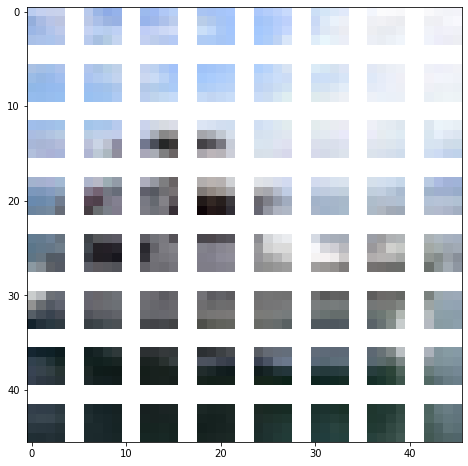

In [24]:
steps = (img_size-size)//size+1 # 一辺の分割回数、今のストライドなら=P
full_img = np.ones(((size+2)*steps-2, (size+2)*steps-2, 3))
batch_idx = -1

for i in range(steps):
  for j in range(steps):
    idx = i*steps+j
    full_img[(size+2)*i:(size+2)*i+size, (size+2)*j:(size+2)*j+size, :] = img_array[batch_idx, idx]

plt.figure(figsize=(8,8))
plt.imshow(full_img)

In [25]:
from wandb.keras import WandbCallback

def scheduler(epoch, lr):
  if epoch < 20:
    return lr
  else:
    return lr * tf.math.exp(-0.2)

N_train = x_train.shape[0]
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

model.compile("adam", "categorical_crossentropy", metrics=["accuracy"])
history = model.fit(train_generator, 
                    validation_data=(x_val, y_val),
                    steps_per_epoch=N_train//config['batch_size'],
                    epochs= config['epochs'],
                    verbose=1,
                    callbacks=[callback,
                               WandbCallback()],
                    )

Epoch 1/64
175/175 [==============================] - 32s 157ms/step - loss: 1.8797 - accuracy: 0.3170 - val_loss: 1.6525 - val_accuracy: 0.3990


wandb: ERROR Can't save model, h5py returned error: Layer MixerBlock has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/64
175/175 [==============================] - 27s 154ms/step - loss: 1.5468 - accuracy: 0.4391 - val_loss: 1.4262 - val_accuracy: 0.4884
Epoch 3/64
175/175 [==============================] - 27s 153ms/step - loss: 1.4188 - accuracy: 0.4914 - val_loss: 1.3554 - val_accuracy: 0.5116
Epoch 4/64
175/175 [==============================] - 27s 152ms/step - loss: 1.3265 - accuracy: 0.5228 - val_loss: 1.2837 - val_accuracy: 0.5386
Epoch 5/64
175/175 [==============================] - 27s 152ms/step - loss: 1.2641 - accuracy: 0.5454 - val_loss: 1.2527 - val_accuracy: 0.5440
Epoch 6/64
175/175 [==============================] - 27s 153ms/step - loss: 1.2296 - accuracy: 0.5564 - val_loss: 1.2887 - val_accuracy: 0.5348
Epoch 7/64
175/175 [==============================] - 27s 153ms/step - loss: 1.1827 - accuracy: 0.5769 - val_loss: 1.2048 - val_accuracy: 0.5666
Epoch 8/64
175/175 [==============================] - 27s 153ms/step - loss: 1.1563 - accuracy: 0.5873 - val_loss: 1.2130 - val_ac

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  after removing the cwd from sys.path.


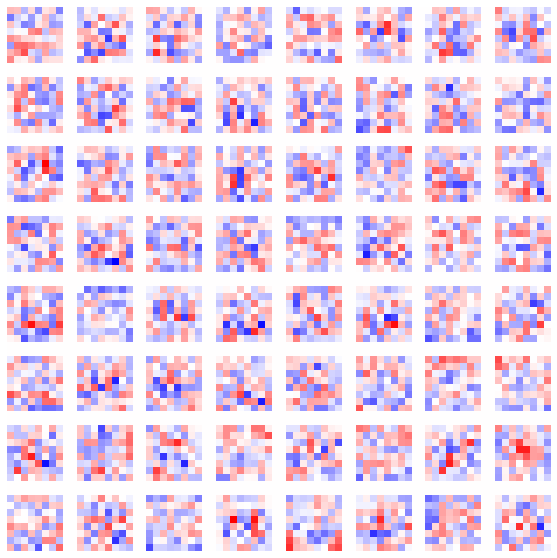

In [26]:
import matplotlib.colors as mcolors

def get_model(i, **config):
  norm = mcolors.DivergingNorm(vcenter=0.0)

  weights = model.layers[i].get_weights()[0].reshape((config['patch_size'], config['patch_size'], config['tokens_mlp_dim']))
  num_h = int(np.sqrt(config['hidden_dim']))
  num_w = config['hidden_dim']//num_h
  full_img = np.zeros(((config['patch_size']+2)*num_h-2, (config['patch_size']+2)*num_w-2))

  for i in range(num_h):
    for j in range(num_w):
      idx = config['patch_size']*i+j
      full_img[(config['patch_size']+2)*i:(config['patch_size']+2)*i+config['patch_size'], (config['patch_size']+2)*j:(config['patch_size']+2)*j+config['patch_size']] = weights[:, :, idx]

  plt.figure(figsize=(10,10))
  plt.imshow(full_img, cmap='bwr', norm=norm)
  plt.axis("off")


get_model(i=3, **config)